<a href="https://colab.research.google.com/github/MinhVuong2000/junior_HCMUS/blob/main/AI_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab03: MLP

---
MSSV: 18120265

Họ và tên: NGUYỄN THỊ MINH VƯỢNG

## Import

In [ ]:
%matplotlib inline
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle

# ignore warning ...
import warnings
import math
warnings.filterwarnings('ignore')

## Định nghĩa các hàm
**Hàm đọc bộ dữ liệu CIFAR-10**

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict
def read_data(containing_dir, num_train_batchs):
    # Read training data
    train_X_batchs = []
    train_Y_batchs = []
    for batch_idx in range(num_train_batchs):
        batch = unpickle(containing_dir + '/data_batch_' + str(batch_idx + 1))
        train_X_batchs.append(batch['data'])
        train_Y_batchs.append(np.array(batch['labels']).reshape(-1, 1))
    train_X = np.vstack(train_X_batchs)
    train_X = train_X / 255. # Normalize to [0, 1]
    train_X = np.hstack([np.ones((len(train_X), 1)), train_X])
    train_Y = np.vstack(train_Y_batchs)
    
    # Read test data
    batch = unpickle(containing_dir + '/test_batch')
    test_X = batch['data']
    test_X = test_X / 255. # Normalize to [0, 1]
    test_X = np.hstack([np.ones((len(test_X), 1)), test_X])
    test_Y = np.array(batch['labels']).reshape(-1, 1)
    
    return (train_X, train_Y, test_X, test_Y)

**Hàm tính output và gradient của Neural Net**

Ở đây, ta dùng hàm kích hoạt sigmoid ở các tầng ẩn, và hàm softmax ở tầng cuối.
Ta có:

$$ h=w^TX $$

$$\text{Sigmoid Activation: } z= \sigma \left(h\right)= \dfrac{1}{1+e^{-h}}$$

$$\text{Cross-entrophy loss: } J(w)=-\left({ylog(z)+(1-y)log(1-z)}\right)$$

$$\text{Chain rule: } \dfrac{\partial J(w)}{\partial w}=\dfrac{\partial J(w)}{\partial z} \dfrac{\partial z}{\partial h}\dfrac{\partial h}{\partial w}  $$

$$\dfrac{\partial J(w)}{\partial z}=-\left(\dfrac{y}{z}-\dfrac{1-y}{1-z}\right)=\dfrac{z-y}{z(1-z)}$$

$$\dfrac{\partial z}{\partial h}=z(1-z)$$

$$\dfrac{\partial h}{\partial w}=X$$

$$\dfrac{\partial J(w)}{\partial w}=X^T(z-y)$$

**Hàm cost và gradient tầng sigmoid:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N-\left({ylog(z)+(1-y)log(1-z)}\right)  $$
$$\text{Gradient: } \dfrac{\partial J(w)}{\partial w}=\dfrac{1}{N}X^T(z-y)$$  

Hàm softmax (C là số lớp): 
$$h(z_i)=\dfrac{e^{z_i}}{\sum_{j=1}^{C}e^{z_j}}$$
**Hàm cost tầng softmax lúc này là:**
$$J(w)=\dfrac{1}{N} \sum_{n=1}^N \sum_{k=1}^K -(y_n)_k log \left(h(x_n)_k\right)  $$

Sử dụng kỹ thuật one-hot-encoding mã hóa tập label y, ta có:
 $$\text{với } (y_n)_k=    \begin{align}
        \begin{cases}
             0 \text { nếu } y_n\neq k\\
             1 \text { nếu } y_n= k\\
        \end{cases}
    \end{align} $$
lúc này số lớp sẽ là 2 hay C=2:

$$h(z_1)=\dfrac{e^{z_1}}{\sum_{j=1}^{2}e^{z_j}}$$

$$h(z_1)=\dfrac{e^{z_1}}{e^{z_1}+e^{z_2}}$$

$$h(z_1)=\dfrac{1}{1+e^{z_2-z_1}}$$

=> Đây chính là hàm sigmoid. Hơn nữa mặc dù có 2 output softmax vẫn có thể rút gọn thành 1 output vì tổng 2 outputs luôn bằng 1

**Do đó hàm cost của tầng softmax và tầng sigmoid là tương tự nhau** 

**=> Gradient của tầng softmax cũng tương tự của tầng sigmoid**

In [ ]:

def sigmoid(x):
    '''
    Computes sigmoid function for each element of array S.
    '''
    return 1 / (1 + np.exp(-x))



def gradient_sigmoid(As, Ws ,mb_X,delta, i):
    '''
    Computes gradient vector for sigmoid layer.
    '''
    delta = delta.dot(Ws[-i+1].T[:,1:])*As[-i][:,1:]*(1-As[-i][:,1:])
    grad = (1.0/len(mb_X))*As[-i-1].T.dot(delta)
    return delta, grad


def softmax(S):
    '''
    Computes softmax function for each row of array S.
    '''
    A = np.exp(S)
    A /=A.sum(axis=1, keepdims=True)

    return A

def gradient_softmax(As,mb_X,mb_Y):
    '''
    Computes gradient vector for softmaz layer
    '''
    delta = As[-1]-mb_Y
    grad = (1.0/len(mb_X))* As[-2].T.dot(delta)
    return delta, grad

def compute_nnet_outputs(Ws, X, need_all_layer_outputs):
    '''
    Computes the outputs of Neural Net by forward propagating X through the net.
    '''
    As = []
    As.append(X)
    As.append(sigmoid(X.dot(Ws[0])))
    As[1] = np.hstack([np.ones((len(As[1]),1)),As[1]])
    A = softmax(As[1].dot(Ws[1]))
    As.append(A)
    if need_all_layer_outputs:
        return As
    else:
        return A

**Các hàm khởi tạo tham số**

In [ ]:

def compute_layer_sizes(X, Y, hid_layer_sizes):
    num_classes = len(np.unique(Y)) # Num classes
    layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [num_classes]
    print('Layer Sizes: ',layer_sizes)
    return layer_sizes


def one_hot_encoding(Y, num_classes):
    num_classes = len(np.unique(Y)) # Num classes
    one_hot_Y = np.zeros((len(Y), num_classes))
    one_hot_Y[np.arange(len(Y)), Y.reshape(-1)] = 1
    return one_hot_Y


def init_weight_matrix(X,Y,layer_sizes):
    #fix random for same result when init weight matrix
    np.random.seed(0) 
    Ws = np.array([np.random.randn(layer_sizes[i]+1 , layer_sizes[i + 1]) / np.sqrt(layer_sizes[i]+1) 
          for i in range(len(layer_sizes) - 1)]) # Init Ws
    print('Weight matrix shape: ',Ws[0].shape,Ws[1].shape)
    return Ws

**Hàm huấn luyện Neural net**

In [ ]:

def updateWeights(Ws,As,mb_X, mb_Y,  learning_rate):
    #update weights for softmax layer
    delta, grad = gradient_softmax(As,mb_X, mb_Y)
    Ws[len(Ws)-1] -= learning_rate * grad
    
    #update weights for hidden layer
    for i in range (2,len(Ws)+1):
      delta, grad = gradient_sigmoid(As,Ws,mb_X,delta,i)
      Ws[len(Ws)-i] -= learning_rate * grad 

    return Ws

def train_nnet(X, Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    
    #get layer sizes:
    layer_sizes = compute_layer_sizes(X, Y, hid_layer_sizes)

    
    # Prepare for training
    Ws=init_weight_matrix(X,Y,layer_sizes)
    one_hot_Y=one_hot_encoding(Y,layer_sizes[-1])
    
    costs = [] # To save costs during training
    errs = [] # To save mean binary errors during training
    N = len(X) # Num training examples
    rnd_idxs = list(range(N)) # Random indexes    
    
    # Train
    for epoch in list(range(max_epoch)):
        #shuffle index
        np.random.shuffle(rnd_idxs)
        for start_idx in list(range(0, N, mb_size)):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            Ws=updateWeights(Ws,As,mb_X,mb_Y,learning_rate)   

        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        costs.append(cost)
        errs.append(err)
        print ('Epoch %d, cost %.3f, err %.3f%%' %(epoch, cost, err))
            
    return Ws, costs, errs

## Chạy

#### Import data

In [ ]:
!import file from kaggle
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d minhvuong2000/cifar10
!ls

/bin/bash: import: command not found


Saving kaggle.json to kaggle (1).json
cifar10.zip: Skipping, found more recently modified local copy (use --force to force download)
 cifar10.zip    files		   kaggle.json
 figure_2.png  'kaggle (1).json'   sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('cifar10.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
!ls files

cifar-10-batches-py


**1.** Đọc dữ liệu (cần đặt thư mục chứa dữ liệu `cifar-10-batches-py` vào cùng thư mục chứa file notebook này)

In [ ]:
num_train_batchs = 3 
train_X, train_Y, test_X, test_Y = read_data('files/cifar-10-batches-py', num_train_batchs)
print ('train_X.shape = %s, train_Y.shape = %s' %(train_X.shape, train_Y.shape))
print ('test_X.shape  = %s, test_Y.shape  = %s' %(test_X.shape, test_Y.shape))

train_X.shape = (30000, 3073), train_Y.shape = (30000, 1)
test_X.shape  = (10000, 3073), test_Y.shape  = (10000, 1)


#### Traning  network

**2.** Để thấy được sự ảnh hưởng của số lượng nơ-ron ẩn, ta sẽ lần lượt huấn luyện Neural Net với `hid_layer_sizes = [50]`, `[100]`, và `[200]` (cố định `mb_size = 32`, `learning_rate = 0.01`, `max_epoch = 200`)

In [ ]:
W_0, costs_0, errs_0 = train_nnet(train_X, train_Y, [50], 32, 0.01, 200)

Layer Sizes:  [3072, 50, 10]
Weight matrix shape:  (3073, 50) (51, 10)
Epoch 0, cost 2.058, err 71.193%
Epoch 1, cost 1.955, err 68.027%
Epoch 2, cost 1.899, err 65.637%
Epoch 3, cost 1.868, err 65.903%
Epoch 4, cost 1.834, err 63.603%
Epoch 5, cost 1.819, err 63.923%
Epoch 6, cost 1.796, err 62.457%
Epoch 7, cost 1.779, err 62.110%
Epoch 8, cost 1.771, err 61.693%
Epoch 9, cost 1.757, err 61.413%
Epoch 10, cost 1.741, err 60.633%
Epoch 11, cost 1.733, err 60.643%
Epoch 12, cost 1.718, err 59.693%
Epoch 13, cost 1.711, err 59.637%
Epoch 14, cost 1.715, err 60.050%
Epoch 15, cost 1.691, err 58.993%
Epoch 16, cost 1.705, err 59.527%
Epoch 17, cost 1.679, err 58.890%
Epoch 18, cost 1.667, err 58.060%
Epoch 19, cost 1.662, err 58.117%
Epoch 20, cost 1.659, err 57.680%
Epoch 21, cost 1.638, err 56.930%
Epoch 22, cost 1.629, err 56.533%
Epoch 23, cost 1.628, err 56.957%
Epoch 24, cost 1.614, err 56.483%
Epoch 25, cost 1.612, err 56.473%
Epoch 26, cost 1.604, err 56.117%
Epoch 27, cost 1.600,

In [ ]:
W_1, costs_1, errs_1 = train_nnet(train_X, train_Y, [100], 32, 0.01, 200)

Layer Sizes:  [3072, 100, 10]
Weight matrix shape:  (3073, 100) (101, 10)
Epoch 0, cost 2.048, err 71.003%
Epoch 1, cost 1.941, err 66.537%
Epoch 2, cost 1.886, err 65.137%
Epoch 3, cost 1.856, err 64.937%
Epoch 4, cost 1.825, err 63.070%
Epoch 5, cost 1.807, err 62.647%
Epoch 6, cost 1.794, err 62.510%
Epoch 7, cost 1.783, err 62.320%
Epoch 8, cost 1.765, err 61.820%
Epoch 9, cost 1.759, err 61.517%
Epoch 10, cost 1.746, err 61.283%
Epoch 11, cost 1.733, err 60.147%
Epoch 12, cost 1.720, err 59.370%
Epoch 13, cost 1.716, err 59.997%
Epoch 14, cost 1.711, err 59.843%
Epoch 15, cost 1.690, err 58.557%
Epoch 16, cost 1.689, err 58.380%
Epoch 17, cost 1.679, err 59.233%
Epoch 18, cost 1.657, err 57.567%
Epoch 19, cost 1.650, err 57.280%
Epoch 20, cost 1.644, err 57.530%
Epoch 21, cost 1.642, err 56.933%
Epoch 22, cost 1.632, err 56.767%
Epoch 23, cost 1.625, err 56.490%
Epoch 24, cost 1.616, err 56.467%
Epoch 25, cost 1.616, err 56.413%
Epoch 26, cost 1.599, err 55.770%
Epoch 27, cost 1.5

In [ ]:
W_2, costs_2, errs_2 = train_nnet(train_X, train_Y, [200], 32, 0.01, 200)

Layer Sizes:  [3072, 200, 10]
Weight matrix shape:  (3073, 200) (201, 10)
Epoch 0, cost 2.030, err 72.230%
Epoch 1, cost 1.931, err 68.573%
Epoch 2, cost 1.882, err 66.007%
Epoch 3, cost 1.849, err 64.307%
Epoch 4, cost 1.833, err 64.810%
Epoch 5, cost 1.812, err 63.287%
Epoch 6, cost 1.785, err 61.727%
Epoch 7, cost 1.777, err 61.900%
Epoch 8, cost 1.770, err 61.673%
Epoch 9, cost 1.764, err 60.757%
Epoch 10, cost 1.743, err 60.393%
Epoch 11, cost 1.752, err 62.213%
Epoch 12, cost 1.724, err 59.677%
Epoch 13, cost 1.721, err 59.883%
Epoch 14, cost 1.707, err 58.793%
Epoch 15, cost 1.703, err 58.823%
Epoch 16, cost 1.699, err 59.310%
Epoch 17, cost 1.688, err 58.680%
Epoch 18, cost 1.678, err 58.227%
Epoch 19, cost 1.665, err 57.763%
Epoch 20, cost 1.658, err 57.533%
Epoch 21, cost 1.650, err 57.127%
Epoch 22, cost 1.656, err 58.173%
Epoch 23, cost 1.651, err 57.927%
Epoch 24, cost 1.619, err 56.353%
Epoch 25, cost 1.610, err 55.910%
Epoch 26, cost 1.609, err 56.147%
Epoch 27, cost 1.6

#### Show comparing models

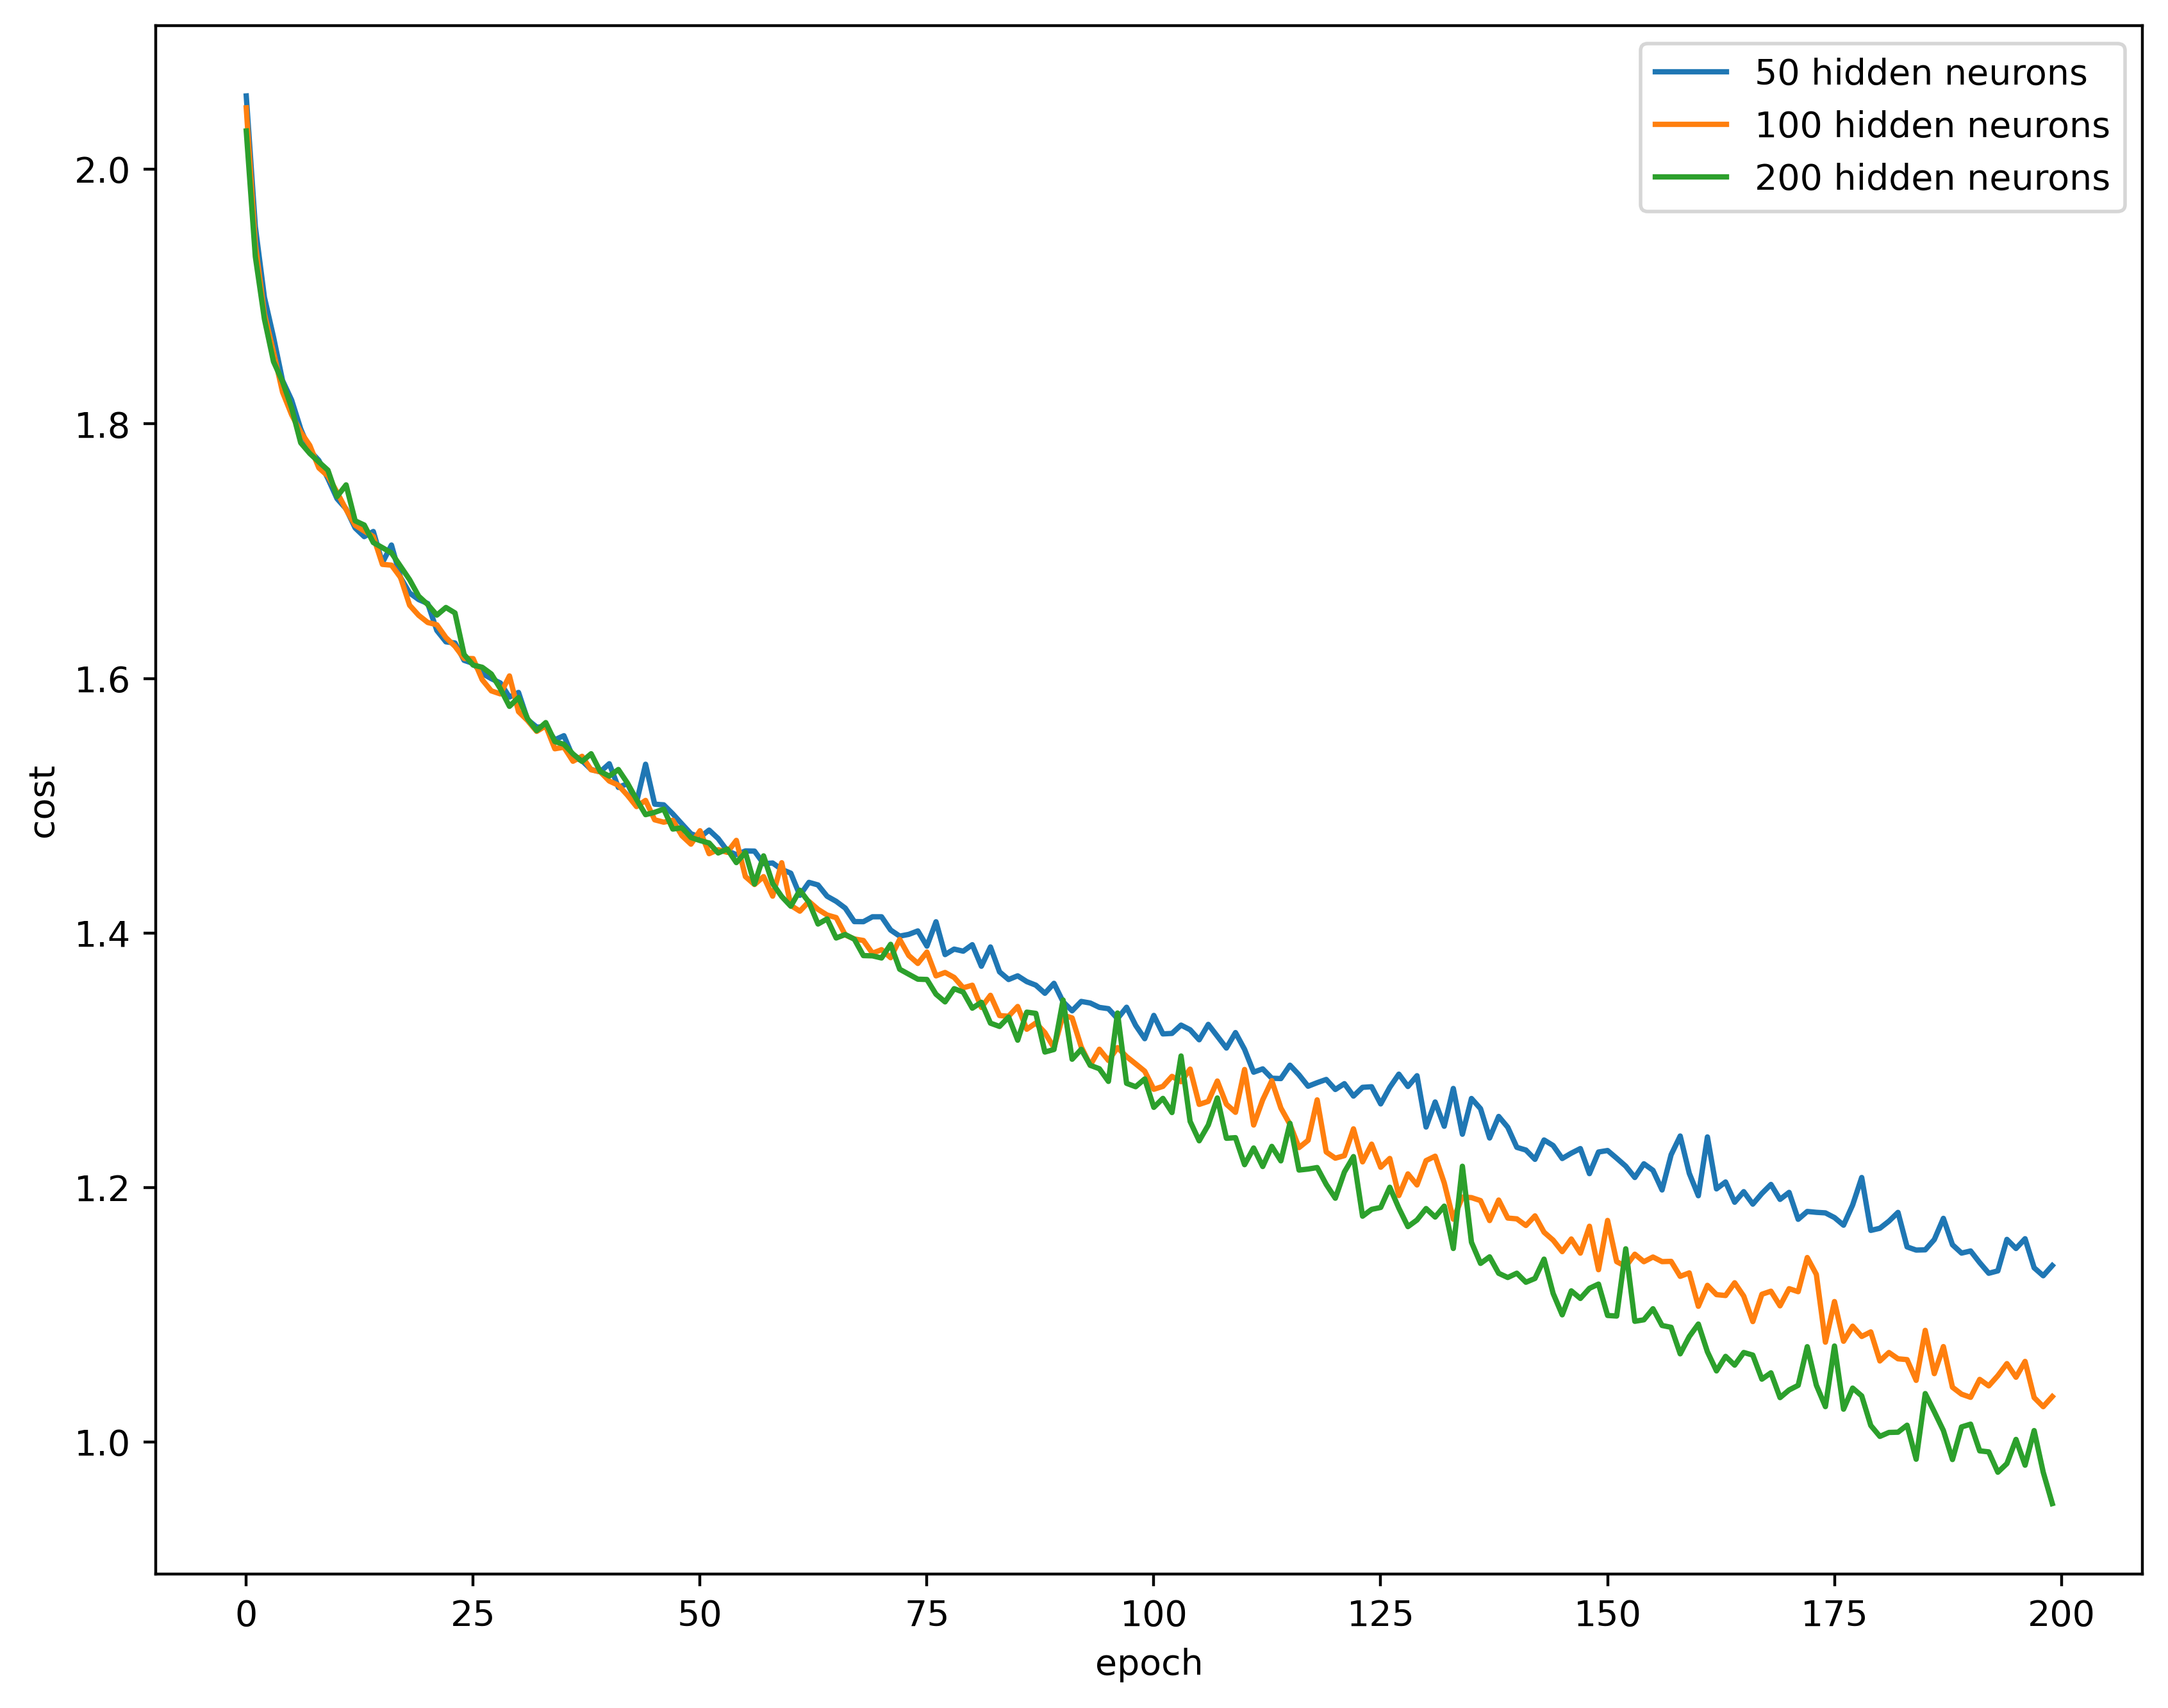

In [ ]:
# Visualize results
epochs = np.arange(len(costs_0))
plt.figure(figsize=(10,8),dpi=400)
plt.plot(epochs, costs_0, label='50 hidden neurons')
plt.plot(epochs, costs_1, label='100 hidden neurons')
plt.plot(epochs, costs_2, label='200 hidden neurons')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend(loc='best')
plt.savefig('figure_1.png')

## Đánh giá mô  hình

Trong 3 hidden-layer-size, số hidden-layer là 200 cho kết quả học tốt nhất. Nên em sẽ dùng nó để đánh giá mô hình với tập test

##### Compare error in training data and test data

In [ ]:
def train_val_nnet(X, Y,test_X, test_Y, hid_layer_sizes, mb_size, learning_rate, max_epoch):
    
    #get layer sizes:
    layer_sizes = compute_layer_sizes(X, Y, hid_layer_sizes)

    
    # Prepare for training
    Ws=init_weight_matrix(X,Y,layer_sizes)
    one_hot_Y=one_hot_encoding(Y,layer_sizes[-1])
    
    costs = [] # To save costs during training
    errs_train = [] # To save mean binary errors during training
    errs_val = [] # To save mean binary errors on testing data
    N = len(X) # Num training examples
    rnd_idxs = list(range(N)) # Random indexes    
    
    # Train
    for epoch in list(range(max_epoch)):
        #shuffle index
        np.random.shuffle(rnd_idxs)
        for start_idx in list(range(0, N, mb_size)):
            # Get minibach
            mb_X = X[rnd_idxs[start_idx:start_idx+mb_size]]
            mb_Y = one_hot_Y[rnd_idxs[start_idx:start_idx+mb_size]]
            
            # Forward-prop
            As = compute_nnet_outputs(Ws, mb_X, True)
            
            # Back-prop; on the way, compute each layer's gradient and update its W
            Ws=updateWeights(Ws,As,mb_X,mb_Y,learning_rate)   

        
        # Compute training info, save it, and print it
        A = compute_nnet_outputs(Ws, X, False)
        B = compute_nnet_outputs(Ws, test_X, False)
        cost = np.mean(-np.sum(one_hot_Y * np.log(A), axis=1))
        err_train = np.mean(np.argmax(A, axis=1) != Y.squeeze()) * 100
        err_val = np.mean(np.argmax(B, axis=1) != test_Y.squeeze()) * 100
        costs.append(cost)
        errs_train.append(err_train)
        errs_val.append(err_val)
        print ('Epoch %d, cost %.3f, err_train %.3f%%, err_test %.3f%%' %(epoch, cost, err_train, err_val))
            
    return Ws, costs, errs_train, errs_val

In [ ]:
W, cost, errs_train, errs_test = train_val_nnet(train_X, train_Y,test_X, test_Y, [200], 32, 0.01, 200)

Layer Sizes:  [3072, 200, 10]
Weight matrix shape:  (3073, 200) (201, 10)
Epoch 0, cost 2.030, err_train 72.230%, err_test 72.170%
Epoch 1, cost 1.931, err_train 68.573%, err_test 68.540%
Epoch 2, cost 1.882, err_train 66.007%, err_test 66.390%
Epoch 3, cost 1.849, err_train 64.307%, err_test 64.910%
Epoch 4, cost 1.833, err_train 64.810%, err_test 64.860%
Epoch 5, cost 1.812, err_train 63.287%, err_test 63.990%
Epoch 6, cost 1.785, err_train 61.727%, err_test 61.930%
Epoch 7, cost 1.777, err_train 61.900%, err_test 62.160%
Epoch 8, cost 1.770, err_train 61.673%, err_test 62.760%
Epoch 9, cost 1.764, err_train 60.757%, err_test 61.750%
Epoch 10, cost 1.743, err_train 60.393%, err_test 61.250%
Epoch 11, cost 1.752, err_train 62.213%, err_test 62.820%
Epoch 12, cost 1.724, err_train 59.677%, err_test 60.600%
Epoch 13, cost 1.721, err_train 59.883%, err_test 60.930%
Epoch 14, cost 1.707, err_train 58.793%, err_test 59.990%
Epoch 15, cost 1.703, err_train 58.823%, err_test 60.010%
Epoch 16

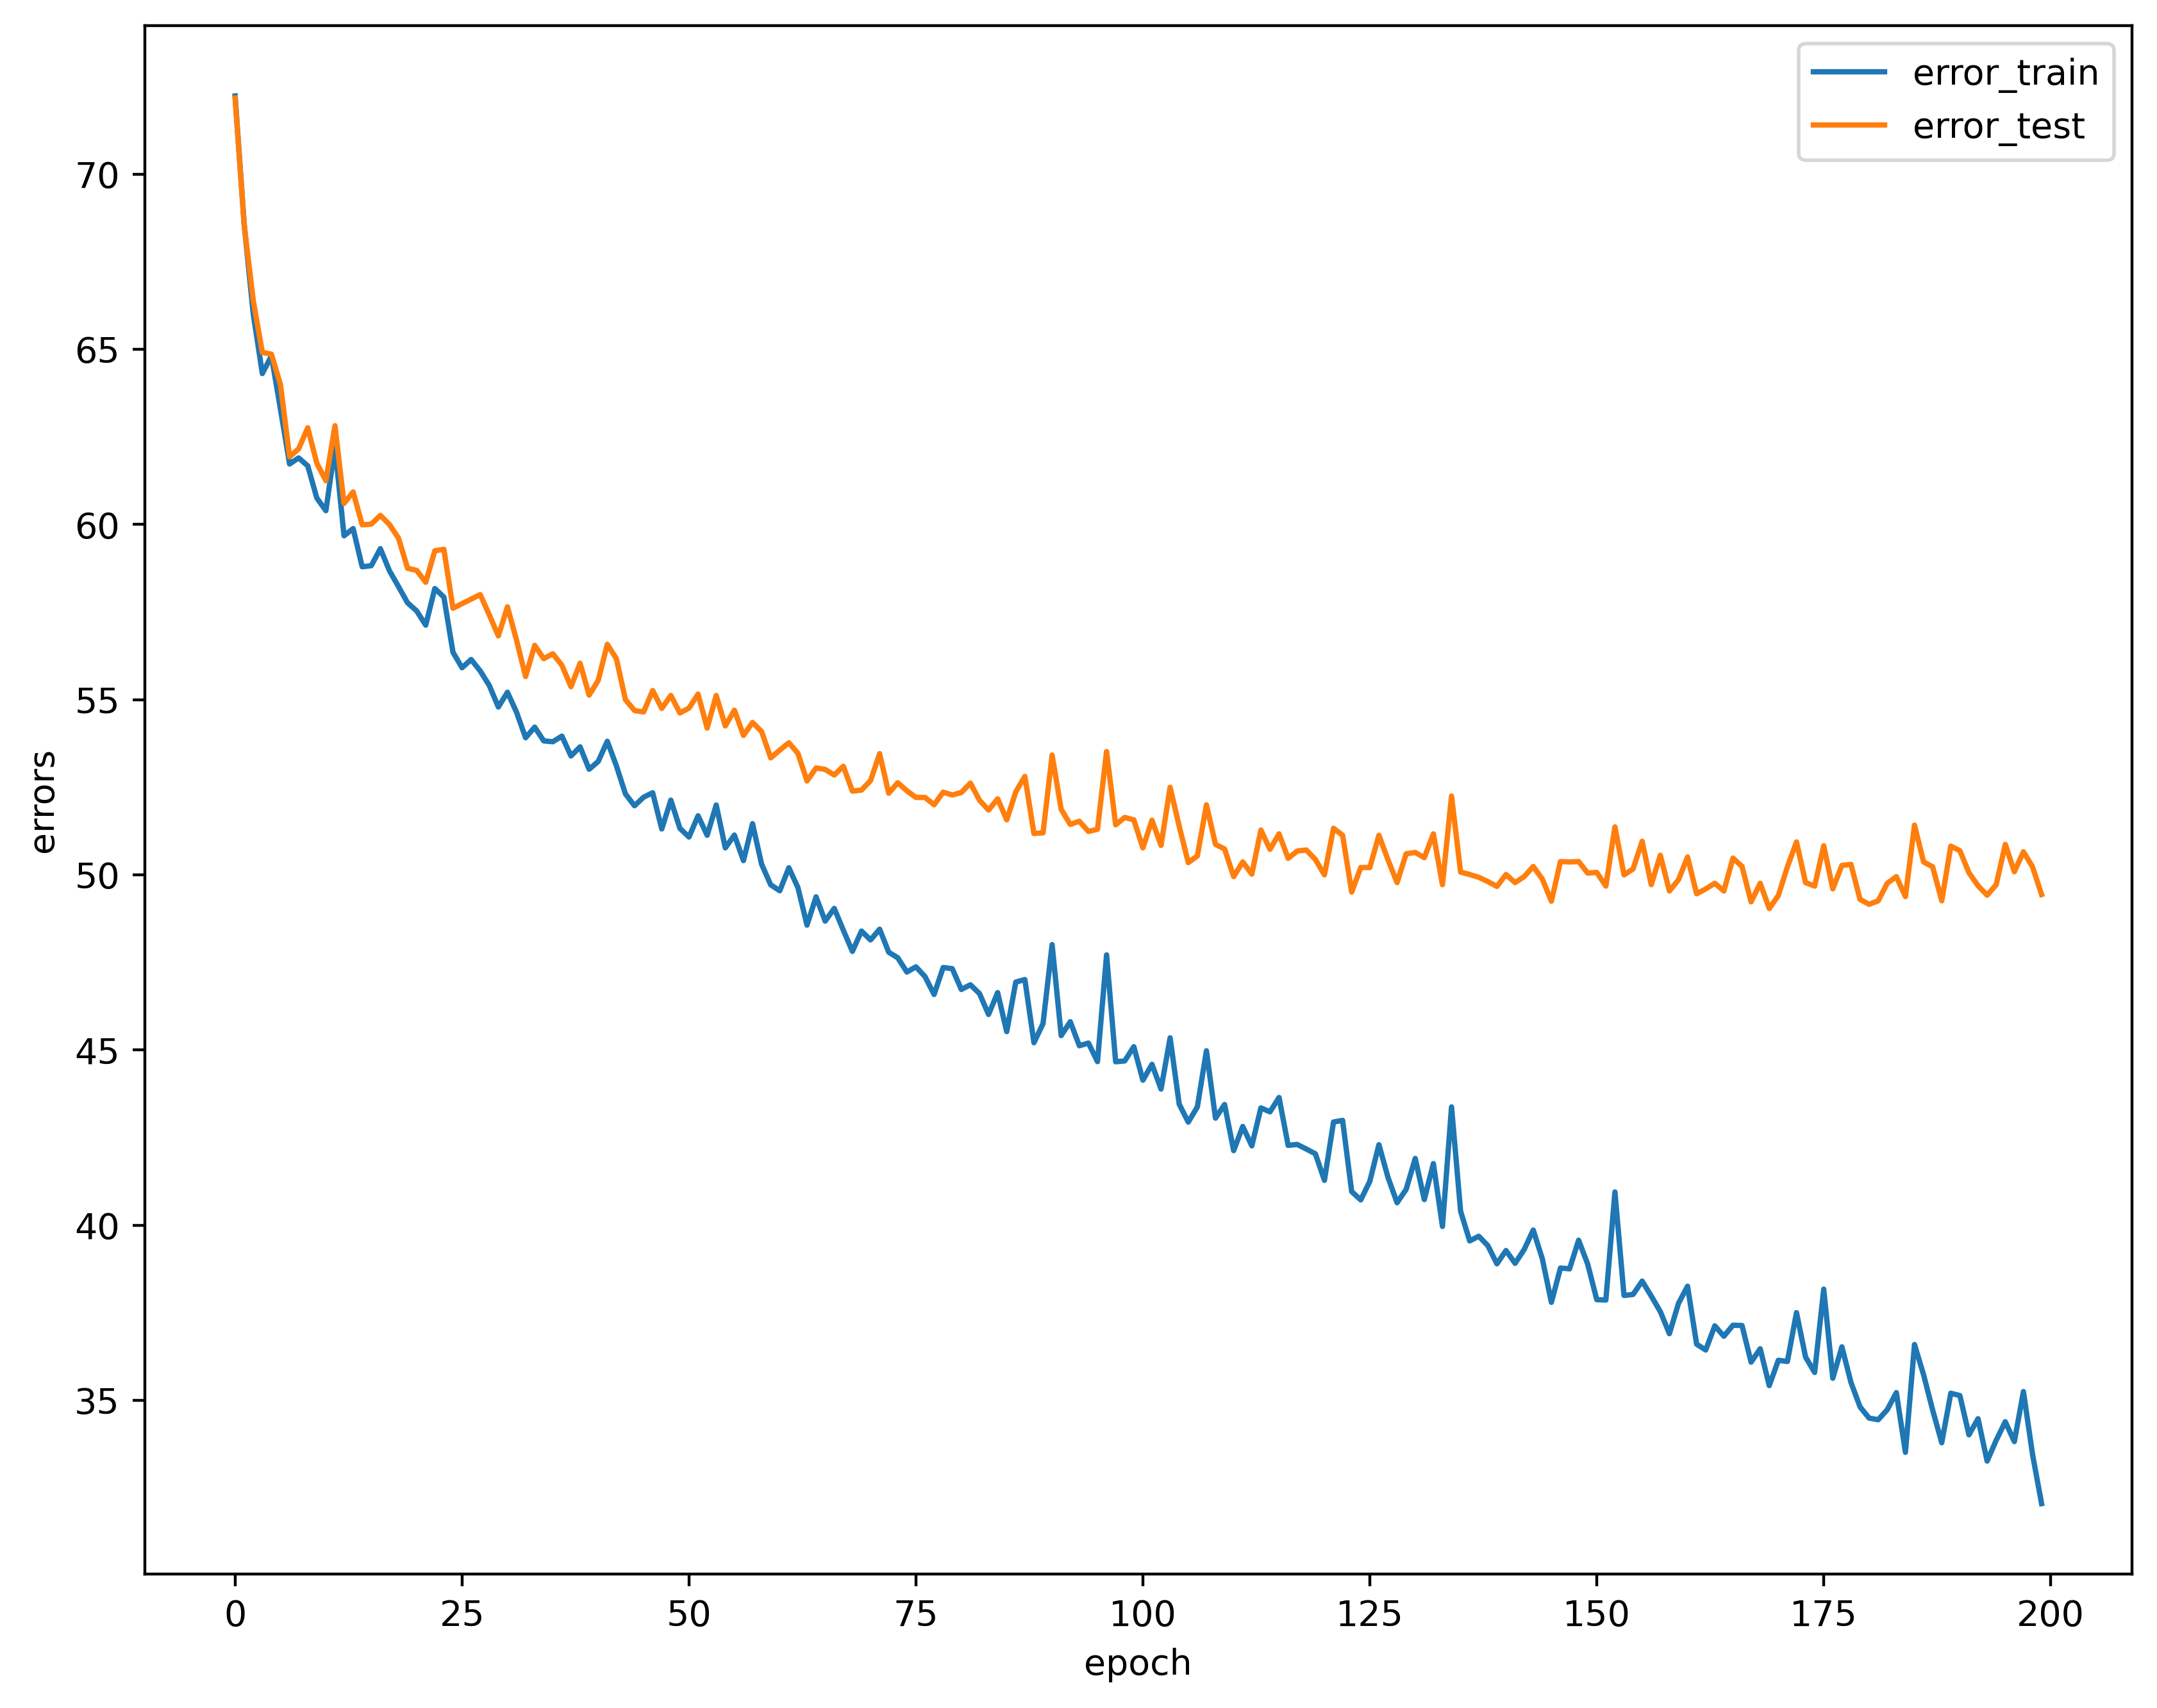

In [ ]:
epochs = np.arange(len(cost))
plt.figure(figsize=(10,8),dpi=400)
plt.plot(epochs, errs_train, label='error_train')
plt.plot(epochs, errs_test, label='error_test')
plt.xlabel('epoch')
plt.ylabel('errors')
plt.legend(loc='best')
plt.savefig('figure_2.png')

### Để đánh giá một mô hình học là tốt hay không, người ta có các cách đo lường phổ biến như:
1. Accuracy: tỉ lệ quan sát đúng trên tất cả các quan sát
$$ accuracy = \dfrac{TP + TN}{TP + FP + FN + TN}$$ 
2. Precision: tỉ lệ quan sát đúng trên tập quan sát cho kết quả dự đoán đúng
$$ precision = \dfrac{TP}{TP + FP}$$
3. Recall: tỉ lệ quan sát đúng trên tập quan sát mà kết quả thực tế đúng
$$ recall = \dfrac{TP}{TP + FN}$$
4. F1-score: là harmonic mean của precision và recall.
$$ F1\_score = \dfrac{2}{\dfrac{1}{precision} + \dfrac{1}{recall}}$$



### Đánh giá

- Theo như tài liệu của Cifar-10, dữ liệu các classes lấy để train hay test cho mỗi batch là random, và có thể có sự khác nhau về số lượng dữ liệu mỗi class, do đó dữ liệu của ta là dữ liệu không đối xứng, hay không cân bằng. Vì vậy, việc sử dụng accuracy là không phản ánh được đúng khả năng học của model. 
- Đối với dữ liệu bất đối xứng, ta nên sử dụng precision, recall hay f1-score. Precision cao đồng nghĩa với việc độ chính xác của các điểm tìm được là cao. Recall cao đồng nghĩa với việc tỉ lệ bỏ sót các điểm thực sự positive là thấp. Nếu ta chỉ dựa vào precision hay recall thì có thể xảy ra các trường hợp như precision cao nhưng recall thấp hay ngược lại, khi đó có thể bỏ sót nhiều dữ liệu có ý nghĩa. Do đó, em lựa chọn f1-score: là harmonic mean của precision và recall, không có sự thiên vị về bên nào ( precision hay recall), nên có tính công bằng và đánh giá toàn diện hơn.

In [ ]:
#không dùng thư viện
pred = compute_nnet_outputs(W, test_X, False)
pred = np.argmax(pred, axis=1)

(unique_pred, counts_pred) = np.unique(pred, return_counts=True)
(unique_real, counts_real) = np.unique(test_Y, return_counts=True)

for mclass in unique_real:
  tp = len([i for i in range (len(pred)) if (pred[i]==test_Y[i] and pred[i]==mclass)])
  precision = tp/counts_pred[mclass]
  recall = tp/counts_real[mclass]
  try:
    f1_score = 2 / (1/precision + 1/recall)
  except ZeroDivisionError:
    f1_score = 0
  print ("class %d: precision %.3f, recall %.3f, f1-score %.3f, support %d" %(mclass,precision,recall,f1_score,counts_pred[mclass]))
tp = len([i for i in range (len(pred)) if (pred[i]==test_Y[i])])
f1 = 2*tp/(len(pred)+len(test_Y))
print("All data:%d F1-score %.3f%%" %(len(test_Y),f1*100))

class 0: precision 0.595, recall 0.526, f1-score 0.558, support 884
class 1: precision 0.697, recall 0.526, f1-score 0.599, support 755
class 2: precision 0.395, recall 0.402, f1-score 0.398, support 1019
class 3: precision 0.331, recall 0.400, f1-score 0.362, support 1209
class 4: precision 0.436, recall 0.407, f1-score 0.421, support 933
class 5: precision 0.439, recall 0.333, f1-score 0.379, support 759
class 6: precision 0.501, recall 0.634, f1-score 0.560, support 1265
class 7: precision 0.546, recall 0.595, f1-score 0.569, support 1090
class 8: precision 0.593, recall 0.690, f1-score 0.638, support 1164
class 9: precision 0.589, recall 0.543, f1-score 0.565, support 922
All data:10000 F1-score 50.560%


In [ ]:
#dùng thư viện
from sklearn.metrics import classification_report
pred = compute_nnet_outputs(W, test_X, False)
print(classification_report(test_Y,np.argmax(pred, axis=1)))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56      1000
           1       0.70      0.53      0.60      1000
           2       0.39      0.40      0.40      1000
           3       0.33      0.40      0.36      1000
           4       0.44      0.41      0.42      1000
           5       0.44      0.33      0.38      1000
           6       0.50      0.63      0.56      1000
           7       0.55      0.59      0.57      1000
           8       0.59      0.69      0.64      1000
           9       0.59      0.54      0.57      1000

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.50     10000
weighted avg       0.51      0.51      0.50     10000



#### Nhận xét

1. Từ biểu đồ figure_2, ta có thể thấy, mô hình đã bị overfitting, tức tốt trên tập train, nhưng error trên tập test thì khá lớn.
2. Mô hình có error lớn, f1-score chỉ có 51%, thuộc loại mô hình học trung bình, so với các mô hình hiện đại như CNN, RNN thì kém nhiều